<a href="https://colab.research.google.com/github/marcelcerri/biorreatores/blob/main/Estimativa_de_Urj_com_Differential_Evolution_e_odeint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Dados 'Experimentais' Gerados (Tempo vs Temperatura com Ruído) ---
Tempo (min) | Temperatura Tr (°C)
------------------------------------
       0.00 |               39.98
       0.51 |               38.55
       1.02 |               37.15
       1.53 |               36.10
       2.03 |               34.73
       2.54 |               33.65
       3.05 |               32.48
       3.56 |               31.55
       4.07 |               30.14
       4.58 |               29.76
       5.08 |               28.48
       5.59 |               27.49
       6.10 |               26.61
       6.61 |               26.08
       7.12 |               25.87
       7.63 |               24.66
       8.14 |               23.94
       8.64 |               23.22
       9.15 |               22.64
       9.66 |               21.92
      10.17 |               21.31
      10.68 |               20.73
      11.19 |               20.56
      11.69 |               20.21
      12.20 |               19.12
      12

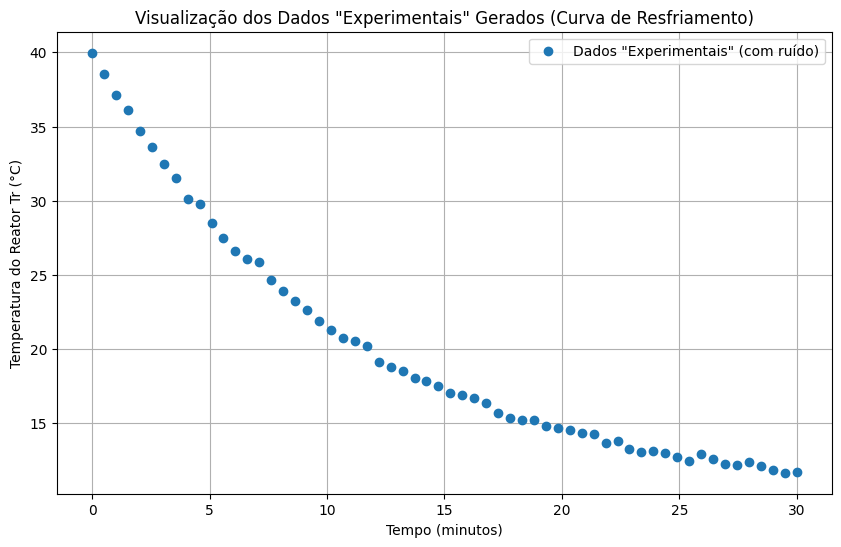

Iniciando otimização com Differential Evolution (usando odeint)...
differential_evolution step 1: f(x)= 12.097522845725514
differential_evolution step 2: f(x)= 5.645694172830038
differential_evolution step 3: f(x)= 5.645694172830038
differential_evolution step 4: f(x)= 1.88510559547853
differential_evolution step 5: f(x)= 1.88510559547853
differential_evolution step 6: f(x)= 1.88510559547853
differential_evolution step 7: f(x)= 1.88510559547853
differential_evolution step 8: f(x)= 1.88510559547853
differential_evolution step 9: f(x)= 1.88510559547853
Polishing solution with 'L-BFGS-B'

Otimização com Differential Evolution concluída.
Valor Verdadeiro de Urj: 250.00 W/m²·K
Valor Estimado de Urj (DE com odeint): 249.93 W/m²·K
Erro final (Soma dos Quadrados) com DE: 1.8851
Número de iterações (gerações): 9
Número de avaliações da função objetivo: 182


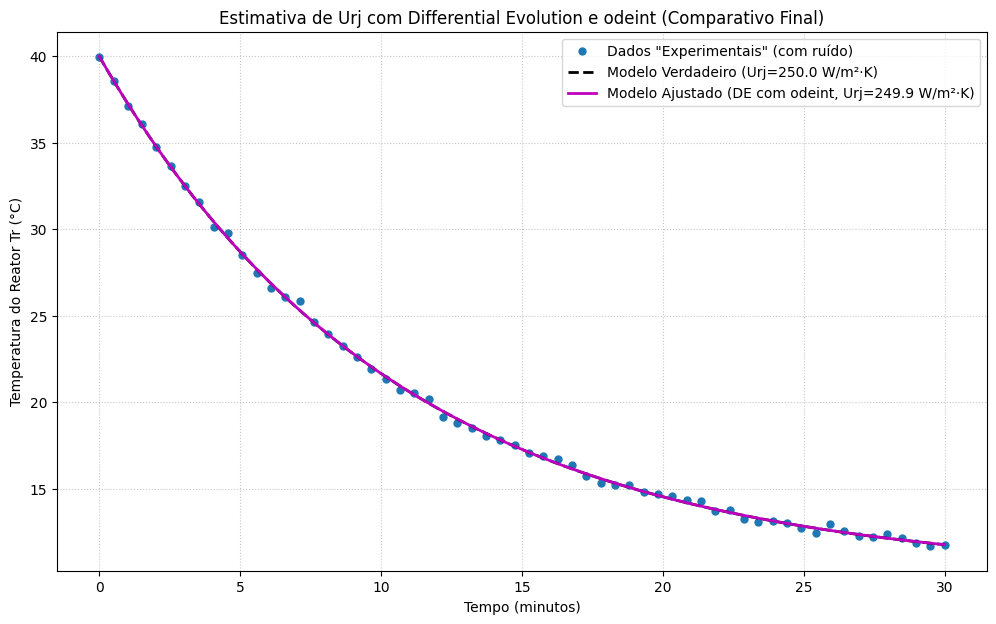

In [1]:
import numpy as np
from scipy.integrate import odeint # Importar odeint em vez de solve_ivp
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# --- PASSO 0: DEFINIÇÃO DOS PARÂMETROS DO SISTEMA E CONSTANTES ---
# Todas as unidades estão no Sistema Internacional (SI), salvo indicação contrária.

# === Parâmetros do Reator ===
V_r = 5.0 / 1000  # Volume do reator (água) [m³] (convertido de 5 Litros)
rho_r = 997.0     # Densidade da água no reator [kg/m³] (aproximadamente a 25°C)
cp_r = 4186.0     # Capacidade calorífica específica da água no reator [J/kg·K]
Mr_Cpr = V_r * rho_r * cp_r  # [J/K]

# === Parâmetros da Jaqueta ===
rho_j = 997.0    # Densidade da água na jaqueta [kg/m³]
cp_j = 4186.0    # Capacidade calorífica específica da água na jaqueta [J/kg·K]
T_jin = 10.0     # Temperatura de entrada da água na jaqueta [°C]
F_j_L_per_min = 2.0 # Vazão da jaqueta [L/min]
F_j = F_j_L_per_min / (60 * 1000) # Vazão da jaqueta convertida para [m³/s]

# === Parâmetros de Transferência de Calor ===
Arj = 0.15       # Área de transferência de calor reator-jaqueta [m²] (Valor estimado/exemplo)

# === Condições Iniciais e Configuração da Simulação ===
Tr_initial = 40.0  # Temperatura inicial do reator [°C]
t_sim_inicio = 0.0 # Tempo inicial da simulação [s]
t_sim_fim = 1800.0 # Tempo final da simulação [s] (equivalente a 30 minutos)
# Para odeint, t_eval (ou t_vec aqui) deve incluir o ponto inicial.
num_pontos_experimentais = 60
t_vec = np.linspace(t_sim_inicio, t_sim_fim, num_pontos_experimentais)

# Valor "Verdadeiro" de Urj para simular os dados experimentais
Urj_verdadeiro = 250.0  # Coeficiente global de transferência de calor [W/m²·K]

# --- PASSO 1: DEFINIÇÃO DO MODELO MATEMÁTICO (EQUAÇÃO DIFERENCIAL ORDINÁRIA) ---
# A assinatura da função para odeint é func(y, t, arg1, arg2, ...).
def dTr_dt_model_odeint(Tr_val, t, Urj, Fj_rho_cp_j_param, Mr_Cpr_param, Arj_param, T_jin_param):
    """
    Calcula a derivada da temperatura do reator (dTr/dt) para uso com odeint.

    Args:
        Tr_val (float): Temperatura atual do reator [°C]. (y na assinatura de odeint)
        t (float): Tempo atual [s]. (t na assinatura de odeint)
        Urj (float): Coeficiente global de transferência de calor [W/m²·K].
        Fj_rho_cp_j_param (float): Produto (Vazão da jaqueta * densidade da jaqueta * cp da jaqueta) [W/K].
        Mr_Cpr_param (float): Capacidade calorífica total do lado do reator [J/K].
        Arj_param (float): Área de transferência de calor reator-jaqueta [m²].
        T_jin_param (float): Temperatura de entrada da água na jaqueta [°C].

    Returns:
        float: Taxa de variação da temperatura do reator, dTr/dt [°C/s].
    """
    if Fj_rho_cp_j_param == 0:
        return 0.0

    denominador_exp = Fj_rho_cp_j_param
    if abs(denominador_exp) < 1e-9:
        denominador_exp = 1e-9 * np.sign(denominador_exp) if denominador_exp != 0 else 1e-9

    arg_exp = -Urj * Arj_param / denominador_exp
    if arg_exp > 700:
        termo_exp = np.inf
    elif arg_exp < -700:
        termo_exp = 0.0
    else:
        termo_exp = np.exp(arg_exp)

    dTrdt = (Fj_rho_cp_j_param / Mr_Cpr_param) * (1 - termo_exp) * (T_jin_param - Tr_val)
    return dTrdt

Fj_rho_cp_j_const = F_j * rho_j * cp_j

# --- PASSO 2: GERAÇÃO DE DADOS "EXPERIMENTAIS" SIMULADOS ---
# Usando odeint
# odeint(func, y0, t, args=(...))
# y0 é a condição inicial
# t é o vetor de tempos para os quais se quer a solução
sol_odeint_verdadeira = odeint(
    dTr_dt_model_odeint,
    Tr_initial,
    t_vec,
    args=(Urj_verdadeiro, Fj_rho_cp_j_const, Mr_Cpr, Arj, T_jin)
)
Tr_experimental_verdadeiro = sol_odeint_verdadeira.flatten() # odeint retorna um array 2D, mesmo para uma única EDO

# --- PASSO 3: ADIÇÃO DE RUÍDO AOS DADOS SIMULADOS ---
ruido_nivel = 0.2
Tr_experimental_ruidoso = Tr_experimental_verdadeiro + np.random.normal(0, ruido_nivel, len(Tr_experimental_verdadeiro))

# --- PASSO 3.1: IMPRESSÃO E VISUALIZAÇÃO DOS DADOS "EXPERIMENTAIS" ---
print("--- Dados 'Experimentais' Gerados (Tempo vs Temperatura com Ruído) ---")
print("Tempo (min) | Temperatura Tr (°C)")
print("------------------------------------")
for i in range(len(t_vec)):
    print(f"{t_vec[i]/60:11.2f} | {Tr_experimental_ruidoso[i]:19.2f}")
print("------------------------------------\n")

plt.figure(figsize=(10, 6))
plt.plot(t_vec / 60, Tr_experimental_ruidoso, 'o', label='Dados "Experimentais" (com ruído)')
plt.xlabel('Tempo (minutos)')
plt.ylabel('Temperatura do Reator Tr (°C)')
plt.title('Visualização dos Dados "Experimentais" Gerados (Curva de Resfriamento)')
plt.legend()
plt.grid(True)
plt.show()

# --- PASSO 4: ESTIMATIVA DE Urj USANDO OTIMIZAÇÃO (DIFFERENTIAL EVOLUTION) ---
# --- PASSO 4.1: DEFINIÇÃO DA FUNÇÃO OBJETIVO (OU FUNÇÃO DE ERRO) ---
def funcao_objetivo_de(params_array):
    Urj_candidato = params_array[0]
    if Urj_candidato <= 0:
        return np.inf

    try:
        sol_estimada_odeint = odeint(
            dTr_dt_model_odeint,
            Tr_initial,
            t_vec, # Usar o mesmo vetor de tempo dos dados experimentais
            args=(Urj_candidato, Fj_rho_cp_j_const, Mr_Cpr, Arj, T_jin)
            # Adicionar tolerâncias se necessário: atol=1e-6, rtol=1e-3
        )
        Tr_simulada = sol_estimada_odeint.flatten()

        # Verificar se o número de pontos simulados corresponde aos experimentais
        if len(Tr_simulada) != len(Tr_experimental_ruidoso):
             # Isso pode acontecer se odeint falhar em algum ponto
            return np.inf

        erro = np.sum((Tr_simulada - Tr_experimental_ruidoso)**2)
    except Exception as e:
        return np.inf
    return erro

# --- PASSO 4.2: DEFINIÇÃO DOS LIMITES (BOUNDS) PARA Urj ---
bounds_Urj = [(10.0, 1000.0)]

# --- PASSO 4.3: EXECUÇÃO DO ALGORITMO DE OTIMIZAÇÃO ---
print("Iniciando otimização com Differential Evolution (usando odeint)...")
resultado_de = differential_evolution(
    func=funcao_objetivo_de,
    bounds=bounds_Urj,
    strategy='best1bin',
    maxiter=100,
    popsize=15,
    tol=0.01,
    mutation=(0.5, 1.0),
    recombination=0.7,
    disp=True,
    polish=True
)

# --- PASSO 4.4: EXTRAÇÃO DOS RESULTADOS DA OTIMIZAÇÃO ---
Urj_estimado_de = resultado_de.x[0]
erro_final_de = resultado_de.fun

print(f"\nOtimização com Differential Evolution concluída.")
print(f"Valor Verdadeiro de Urj: {Urj_verdadeiro:.2f} W/m²·K")
print(f"Valor Estimado de Urj (DE com odeint): {Urj_estimado_de:.2f} W/m²·K")
print(f"Erro final (Soma dos Quadrados) com DE: {erro_final_de:.4f}")
print(f"Número de iterações (gerações): {resultado_de.nit}")
print(f"Número de avaliações da função objetivo: {resultado_de.nfev}")

# --- PASSO 5: PLOTAGEM DOS RESULTADOS FINAIS COMPARATIVOS ---
# Simula a curva de temperatura usando o Urj estimado para visualização.
# Gerar pontos de tempo mais densos para uma curva suave no gráfico final
t_plot_final = np.linspace(t_sim_inicio, t_sim_fim, 200)
sol_final_estimada_de_odeint = odeint(
    dTr_dt_model_odeint,
    Tr_initial,
    t_plot_final, # Usar os tempos mais densos para o plot
    args=(Urj_estimado_de, Fj_rho_cp_j_const, Mr_Cpr, Arj, T_jin)
)
Tr_plot_final_estimada = sol_final_estimada_de_odeint.flatten()

# Para a curva verdadeira, também podemos gerar com mais pontos para o plot
sol_verdadeira_plot = odeint(
    dTr_dt_model_odeint,
    Tr_initial,
    t_plot_final,
    args=(Urj_verdadeiro, Fj_rho_cp_j_const, Mr_Cpr, Arj, T_jin)
)
Tr_plot_verdadeira = sol_verdadeira_plot.flatten()


plt.figure(figsize=(12, 7))
plt.plot(t_vec / 60, Tr_experimental_ruidoso, 'o', markersize=5, label='Dados "Experimentais" (com ruído)')
plt.plot(t_plot_final / 60, Tr_plot_verdadeira, 'k--', linewidth=2, label=f'Modelo Verdadeiro (Urj={Urj_verdadeiro:.1f} W/m²·K)')
plt.plot(t_plot_final / 60, Tr_plot_final_estimada, 'm-', linewidth=2, label=f'Modelo Ajustado (DE com odeint, Urj={Urj_estimado_de:.1f} W/m²·K)')

plt.xlabel('Tempo (minutos)')
plt.ylabel('Temperatura do Reator Tr (°C)')
plt.title('Estimativa de Urj com Differential Evolution e odeint (Comparativo Final)')
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()